# WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [2]:
plt.ion()
plt.rcParams['figure.figsize'] = [16, 8]

## Load Data

In [3]:
# 69 images, each one has 68 points
root_dir = os.path.join('.', 'data', 'faces')
landmark_filename = 'face_landmarks.csv'
full_path = os.path.join(root_dir, landmark_filename)
print(full_path)

landmarks_frame = pd.read_csv(full_path)
print(landmarks_frame.shape)

landmarks_frame

./data/faces/face_landmarks.csv
(69, 137)


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,...,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,...,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,...,85,130,94,130,85,128,81,128,77,128


## Display Image with Landmarks

In [4]:
idx = 65
img_name = landmarks_frame.iloc[idx, 0]
landmarks = landmarks_frame.iloc[idx, 1:]
landmarks = np.asarray(landmarks)
print(landmarks.shape)
landmarks = landmarks.astype('float32').reshape(-1, 2)

print(f'Image name: {img_name}')
print(f'Landmarks shape: {landmarks.shape}')
print('First 4 Landmarks:', landmarks[:4])

(136,)
Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [5]:
def show_landmarks(image, landmarks):
    "show image with landmarks"
    plt.imshow(image)
    plt.scatter(
        landmarks[:, 0], landmarks[:, 1], 
        s=14, marker='.', c='r')

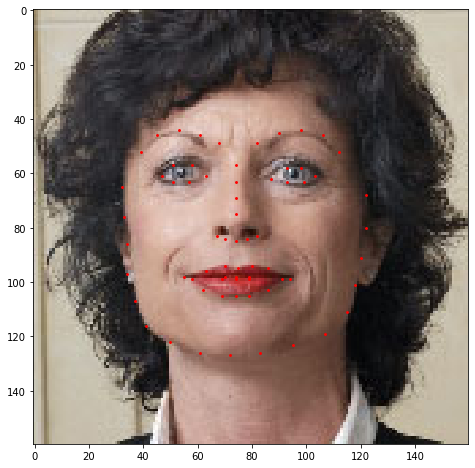

In [6]:
image = io.imread(os.path.join('data', 'faces', img_name))

plt.figure()
show_landmarks(image, landmarks)
plt.show()

## Creating Dataset Class

In [7]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(
            self.root_dir, 
            self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=np.float32)
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
            
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [8]:
face_dataset = FaceLandmarksDataset(
    csv_file=full_path,
    root_dir=root_dir)

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


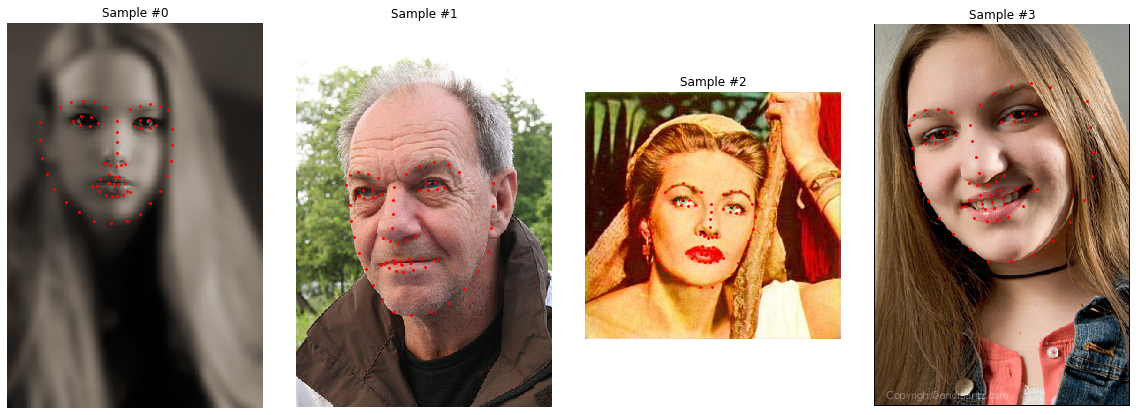

In [9]:
# print 1st 4 samples

fig = plt.figure()

for i in range(4):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(141+i)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')  # turn off x,y axes
    show_landmarks(**sample)
    
plt.show()

## Transforms

1. `Rescale`
1. `RandomCrop`
1. `ToTensor`: Convert numpy images to torch images. We need to swap axes. from (x, y, c) to (c, x, y)

In [10]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks': landmarks}

In [11]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

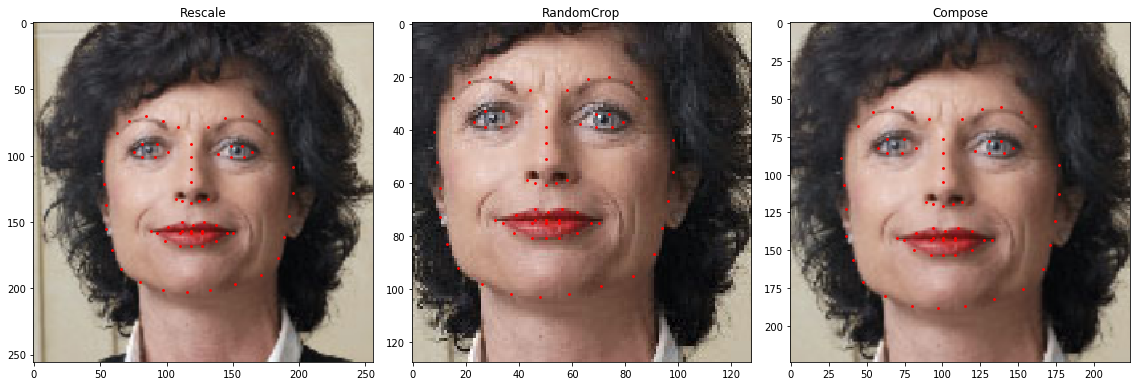

In [13]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(131+i)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterating through the dataset

In [14]:
transformed_dataset = FaceLandmarksDataset(
    csv_file=full_path,
    root_dir=root_dir,
    transform=transforms.Compose([
        Rescale(256),
        RandomCrop(224),
        ToTensor()]))

print(len(transformed_dataset))

for i in range(4):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

69
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


## DataLoader
`for` lacks **Batching**, **Shuffling** and **Parallelizing** features

In [21]:
batch_size = 8
data_loader = DataLoader(
    transformed_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4)

In [22]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(
            landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
            landmarks_batch[i, :, 1].numpy() + grid_border_size,
            s=10, marker='.', c='r')
        
        plt.title('Batch from dataloader')

0 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
1 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
2 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
3 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])


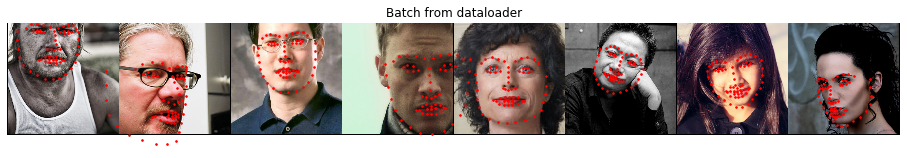

In [23]:
for i_batch, sample_batched in enumerate(data_loader):
    print(
        i_batch, 
        sample_batched['image'].size(),
        sample_batched['landmarks'].size())
    
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Using `torchvision`

In [30]:
data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

print(root_dir)
data = datasets.ImageFolder(
    root='./data/',
    transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(
    data,
    batch_size=4, 
    shuffle=True,
    num_workers=4)

print(len(data))

./data/faces
69
